Let's assume that we're working for an an e-learning company that offers courses on programming. Most of our courses are on web and mobile development, but we also cover many other domains, like data science, game development, etc. We want to promote our product and we'd like to invest some money in advertisement. Our goal in this project is to find out the two best markets to advertise our product in.

# Understanding the Data

In [1]:
import pandas as pd

FCC_survey = pd.read_csv('2017-fCC-New-Coders-Survey-Data.csv',dtype='unicode')
print(FCC_survey.shape)
print(FCC_survey.head(5))

(18175, 136)
  Age AttendedBootcamp BootcampFinish BootcampLoanYesNo BootcampName  \
0  27                0            NaN               NaN          NaN   
1  34                0            NaN               NaN          NaN   
2  21                0            NaN               NaN          NaN   
3  26                0            NaN               NaN          NaN   
4  20                0            NaN               NaN          NaN   

  BootcampRecommend ChildrenNumber                 CityPopulation  \
0               NaN            NaN            more than 1 million   
1               NaN            NaN              less than 100,000   
2               NaN            NaN            more than 1 million   
3               NaN            NaN  between 100,000 and 1 million   
4               NaN            NaN  between 100,000 and 1 million   

  CodeEventConferences CodeEventDjangoGirls         ...         YouTubeFCC  \
0                  NaN                  NaN         ...      

To reach our goal, we could organize surveys for a couple of different markets to find out which would the best choices for advertising. This is very costly, however, and it's a good call to explore cheaper options first.

We can try to search existing data that might be relevant for our purpose. One good candidate is the data from [freeCodeCamp's 2017 New Coder Survey](https://www.freecodecamp.org/news/we-asked-20-000-people-who-they-are-and-how-theyre-learning-to-code-fff5d668969/). [freeCodeCamp](https://www.freecodecamp.org/) is a free e-learning platform that offers courses on web development. Because they run [a popular Medium publication](https://www.freecodecamp.org/news/) (over 400,000 followers), their survey attracted new coders with varying interests (not only web development), which is ideal for the purpose of our analysis.

The survey data is publicly available in this [GitHub repository](https://github.com/freeCodeCamp/2017-new-coder-survey).

# Checking for Sample Representativity

In [2]:
FCC_survey['JobRoleInterest'].value_counts(normalize=True)

Full-Stack Web Developer                                                                                                                                                                                                           0.117706
  Front-End Web Developer                                                                                                                                                                                                          0.064359
  Data Scientist                                                                                                                                                                                                                   0.021739
Back-End Web Developer                                                                                                                                                                                                             0.020309
  Mobile Developer                                      

The table above is a bit granular but from a quick scan, we can see:
- A lot of people are interested in Full-Stack Web Developer
- A few people are interested in Mobile Developer
- A few people are interested in other domains

Many respondents are interested in various fields - this is a good sign for us since new coders tend to interest in different fields. It's good to know the percentage of those who are interested in only 1 subject and the others.

In [3]:
interest_no_nulls = FCC_survey['JobRoleInterest'].dropna()
splitted_interests = interest_no_nulls.str.split(',')

n_options = splitted_interests.apply(lambda x: len(x))
n_options.value_counts(normalize=True) * 100

1     31.650458
3     15.889588
4     15.217391
5     12.042334
2     10.883867
6      6.721968
7      3.861556
8      1.759153
9      0.986842
10     0.471968
12     0.300343
11     0.185927
13     0.028604
Name: JobRoleInterest, dtype: float64

There are 31.7% people are interested in 1 field only. Since most of the courses we offer are on web and mobile development, we would like to know the portion of people who are interested in those fields. 

In [4]:
mobile_web = interest_no_nulls.str.contains("Web Developer|Mobile Developer")
mobile_web = mobile_web.value_counts(normalize=True)*100

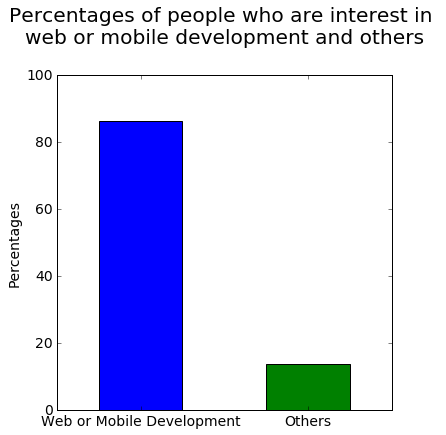

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline 


mobile_web.plot.bar(figsize=(6,6))
plt.style.use('fivethirtyeight')
plt.title('Percentages of people who are interest in \nweb or mobile development and others', y=1.08)
plt.xticks([0,1], ["Web or Mobile Development", "Others"], rotation=0)
plt.ylabel('Percentages')
plt.ylim(0,100)

plt.show()


We can see that more than 80% people are interested in either Web or Mobile Development which makes our sample representative.

Now we need to verify: 
- The locations of new coders - where they actually live while we run ads
- how much money the coders are willing to spend

# Location and Densities

Because the data set provides information at a country level, we can think of each country as an individual market. This means we can frame our goal as finding the two best countries to advertise in.

One indicator of a good market is the number of potential customers — the more potential customers in a market, the better. If our ads manage to convince 10% of the 5000 potential customers in market A to buy our product, then this is better than convincing 100% of the 30 potential customers in market B.

In [6]:
FCC_survey = FCC_survey[FCC_survey['JobRoleInterest'].notnull()].copy()

#generate both absolute and relative frequencies
abs_freq = FCC_survey['CountryLive'].value_counts()
rel_freq = FCC_survey['CountryLive'].value_counts(normalize=True)*100

#generate the table
frequencies = pd.DataFrame(data = {
   'Absolute Frequencies': abs_freq,
    'Relative Frequencies': rel_freq
})

frequencies.head(10)

,Absolute Frequencies,Relative Frequencies
United States of America,3125,45.700497
India,528,7.721556
United Kingdom,315,4.606610
Canada,260,3.802281
Poland,131,1.915765
Brazil,129,1.886517
Germany,125,1.828020
Australia,112,1.637906
Russia,102,1.491664
Ukraine,89,1.301550


Based on the table above,it seems like the USA and India are the two best markets for advertisement - However, we need to figure out how much money people are willing to spend

# Spending Money for Learning

Our company sells subscriptions at a price of $59 per month, and for this reason we're interested in finding out how much money each student spends per month.

It also seems like a good idea to narrow down our analysis to only four countries: the US, India, the United Kingdom, and Canada. Two reasons for this decision are:

These are the countries having the highest absolute frequencies in our sample, which means we have a decent amount of data for each.
Our courses are written in English, and English is an official language in all these four countries. The more people that know English, the better our chances to target the right people with our ads.

The MoneyForLearning column describes in American dollars the amount of money spent by participants from the moment they started coding until the moment they completed the survey. To avoid dividing by 0, replace all the values of 0 with 1.

In [7]:
import numpy as np
FCC_survey['MonthsProgramming'].replace(0,1,inplace=True)
FCC_survey['money_per_month'] = FCC_survey['MoneyForLearning'].astype(float) / FCC_survey['MonthsProgramming'].astype(float)
FCC_survey['money_per_month'].replace(np.inf, np.nan, inplace=True)

FCC_survey['money_per_month'].isnull().sum()
FCC_survey['CountryLive'].value_counts().head(4)

United States of America    3125
India                        528
United Kingdom               315
Canada                       260
Name: CountryLive, dtype: int64

In [8]:
FCC_survey = FCC_survey[FCC_survey['money_per_month'].notnull()]
FCC_survey = FCC_survey[FCC_survey['CountryLive'].notnull()]

FCC_survey['CountryLive'].value_counts().head(4)


United States of America    2810
India                        454
United Kingdom               270
Canada                       235
Name: CountryLive, dtype: int64

In [9]:
FCC_per_country = FCC_survey.groupby('CountryLive').mean()
FCC_per_country['money_per_month'][['United States of America', 
                                    'United Kingdom', 'Canada', 'India']]

CountryLive
United States of America    232.771574
United Kingdom               46.904110
Canada                      107.415450
India                       136.347477
Name: money_per_month, dtype: float64

As per Location and Money Spending, the U.S and India are the 2 best markets that we should consider investing. However, this is suprising if  we considered a few socio-economical metrics (like GDP per capita), we'd intuitively expect people in the UK and Canada to spend more on learning than people in India.

It might be that we don't have have enough representative data for the United Kingdom, Canada, and India, or we have some outliers (maybe coming from wrong survey answers) making the mean too big for India, or too low for the UK and Canada. Or it might be that the results are correct.

# Dealing with Extreme Outliers

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



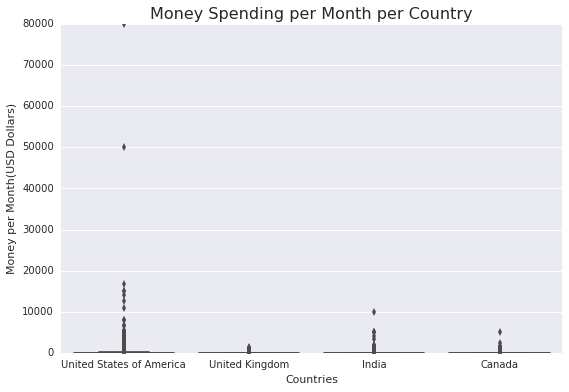

In [10]:
import seaborn as sns

only_4 = FCC_survey[FCC_survey['CountryLive'].str.contains('United States of America|United Kingdom|Canada|India')].copy()
sns.boxplot(x='CountryLive', y='money_per_month', data=only_4)
plt.title('Money Spending per Month per Country', fontsize=16)
plt.ylabel("Money per Month(USD Dollars)")
plt.xlabel("Countries")
plt.legend()

plt.show()

It's hard to see anything wrong for UK, India, Canada but the data in the U.S is unusual - we will eliminate the data which have more than 20K USD per month as it's a bit strange to spend 50K or 80K for online courses

In [11]:
FCC_survey = FCC_survey[FCC_survey["money_per_month"] <= 20000]

In [12]:
countries_mean = FCC_survey.groupby("CountryLive").mean()
countries_mean["money_per_month"][['United States of America', 
                                    'United Kingdom', 'Canada', 'India']]

CountryLive
United States of America    186.641069
United Kingdom               46.904110
Canada                      107.415450
India                       136.347477
Name: money_per_month, dtype: float64

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



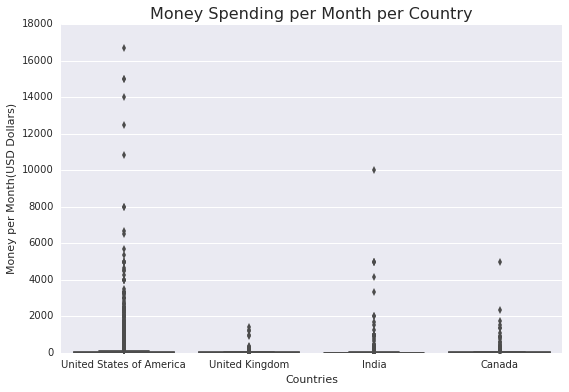

In [15]:
only_4 = FCC_survey[FCC_survey["CountryLive"].str.contains("United States of America|United Kingdom|Canada|India")]

sns.boxplot(x='CountryLive', y='money_per_month', data=only_4)
plt.title('Money Spending per Month per Country', fontsize=16)
plt.ylabel("Money per Month(USD Dollars)")
plt.xlabel("Countries")
plt.legend()

plt.show()

In [23]:
India_outliers = only_4[(only_4["CountryLive"]== "India") & (only_4["money_per_month"]>=2500)]
only_4 = only_4.drop(India_outliers.index)

In [26]:
usa_outliers = only_4[(only_4["CountryLive"]=="United States of America") & (only_4["money_per_month"]>6500)]
usa_outliers

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,money_per_month
718,26,1,0,0,The Coding Boot Camp at UCLA Extension,1,NaN,more than 1 million,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.000000
3930,31,0,NaN,NaN,NaN,NaN,NaN,"between 100,000 and 1 million",NaN,NaN,...,1,1,1,1,1,NaN,various conf presentations,NaN,NaN,10833.333333
6805,46,1,1,1,Sabio.la,0,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000.000000
7198,32,0,NaN,NaN,NaN,NaN,NaN,more than 1 million,1,NaN,...,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,14000.000000
7505,26,1,0,1,Codeup,0,NaN,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,6666.666667
9778,33,1,0,1,Grand Circus,1,NaN,"between 100,000 and 1 million",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000.000000
16650,29,0,NaN,NaN,NaN,NaN,2,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,16666.666667
16997,27,0,NaN,NaN,NaN,NaN,1,more than 1 million,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12500.000000
17231,50,0,NaN,NaN,NaN,NaN,2,"less than 100,000",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000.000000


The outliers in the USA has already attended 1 bootcamp so they won't be our target as we try to aim for new coders

In [27]:
only_4 = only_4.drop(usa_outliers.index)
canada_outliers = only_4[(only_4["CountryLive"]=="Canada") & (only_4["money_per_month"]>=2500)]
canada_outliers

,Age,AttendedBootcamp,BootcampFinish,BootcampLoanYesNo,BootcampName,BootcampRecommend,ChildrenNumber,CityPopulation,CodeEventConferences,CodeEventDjangoGirls,...,YouTubeFunFunFunction,YouTubeGoogleDev,YouTubeLearnCode,YouTubeLevelUpTuts,YouTubeMIT,YouTubeMozillaHacks,YouTubeOther,YouTubeSimplilearn,YouTubeTheNewBoston,money_per_month
13659,24,1,0,0,Bloc.io,1,NaN,more than 1 million,1,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,5000.0


We will also remove the canada outlier as this person has already attended 1 bootcamp

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



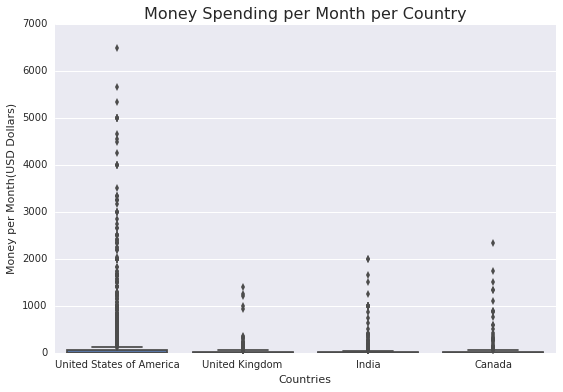

In [28]:
only_4 = only_4.drop(canada_outliers.index)

sns.boxplot(x='CountryLive', y='money_per_month', data=only_4)
plt.title('Money Spending per Month per Country', fontsize=16)
plt.ylabel("Money per Month(USD Dollars)")
plt.xlabel("Countries")
plt.legend()

plt.show()

In [29]:
countries_mean = only_4.groupby("CountryLive").mean()
countries_mean["money_per_month"][['United States of America', 
                                    'United Kingdom', 'Canada', 'India']]

CountryLive
United States of America    149.132353
United Kingdom               46.904110
Canada                       86.506969
India                        65.628917
Name: money_per_month, dtype: float64

# Choosing the Two Best Markets

Based on the numbers above, Canada seems to be the 2nd best market - however, we need to double check how big that market is in our data

In [30]:
only_4["CountryLive"].value_counts(normalize=True) * 100

United States of America    74.620101
India                       11.943482
United Kingdom               7.198081
Canada                       6.238336
Name: CountryLive, dtype: float64

India potential customers are double than its in Canada and because we sells subscriptions at a price of \$59 per month - that's not an expensive amount in India since they spend in average \$65.62 per month
Until this point, there are coupple strategies we can try. We can split our investment in 3 countries unequally:
- 50% in the U.S, 30% in India and 20% in Canada
- 65% in the U.S, 20% in Canada and 15% in India

Or we can invest the amount in 2 countries only - either US and India or either US and Canada. And again, the split will be unequal. For example:
- 80% in the U.S and 20% in Canada 
- 70% in the U.S and 30% in India

Or we can invest in the U.S only

Until this point, it is unclear whether we should invest in Canada or India or both - we need to send our analysis to the marketing team to let them decide

# Conclusion 

In this project, we analyzed survey data from new coders to find the best two markets to advertise in. The only solid conclusion we reached is that the US would be a good market to advertise in.

For the second best market, it wasn't clear-cut what to choose between India and Canada. We decided to send the results to the marketing team so they can use their domain knowledge to take the best decision.